In [2]:
from openqaoa.problems.maximumcut import MaximumCut
from openqaoa.backends import create_device
from qiskit import transpile
import networkx as nx
from openqaoa import QAOA  
from openqaoa.problems import MaximumCut
from openqaoa.utilities import ground_state_hamiltonian,plot_graph
import matplotlib.pyplot as plt
from openqaoa.utilities import plot_graph
from qiskit_aer.noise import (NoiseModel, depolarizing_error)


# Define instance and noise model

In [3]:
one_qubit_gates = ['h','rx']
two_qubits_gates = ['cx']
#create depol. noise
def add_depolarizing_error(noise_model,prob1, prob2):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob1)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob2)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

noise_model = add_depolarizing_error(NoiseModel(),0.0001989 
                                               ,0.007905
                                              ) #ibm_quebec, 19/01/2024
noise_model

<NoiseModel on ['cx', 'h', 'rx']>

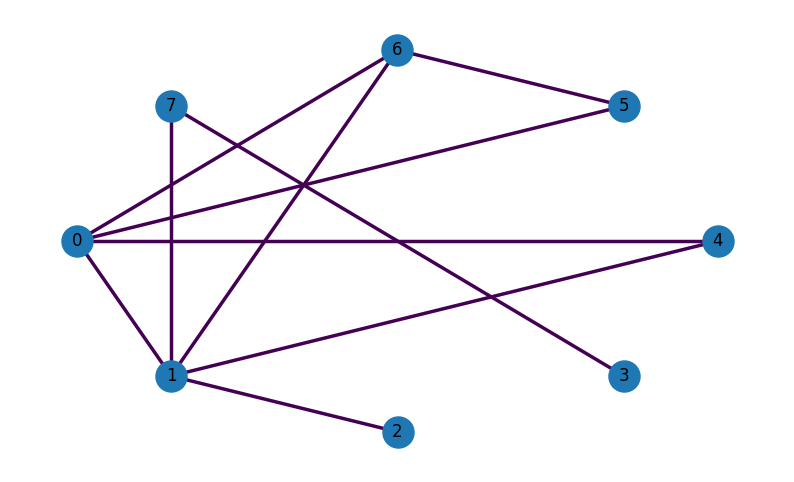

In [14]:
#g = nx.generators.fast_gnp_random_graph(n=7, p=0.3, seed=42)
g = nx.Graph()
g.add_nodes_from([0,1, 2, 3, 4, 5, 6, 7])
g.add_edges_from([(0,5),(0,6),(0,1),(0,4),(5,6),(6,1),(4,1),(1,2),(1,7),(7,3)])

maxcut = MaximumCut(g)
maxcut_qubo = maxcut.qubo

plot_graph(g)

# Noiseless

In [15]:
q1 = QAOA()
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q1.set_device(qiskit_device)
q1.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
q1.set_backend_properties(n_shots=5000)
q1.set_classical_optimizer(method='Powell', maxiter=200, tol=0.01,maxfev=1000, optimization_progress=True, cost_progress=True, parameter_log=True)
q1.compile(maxcut_qubo)
q1.optimize()
opt_results1 = q1.result


{'solutions_bitstrings': ['11010100', '10101011', '01011100', '00101111', '11010000', '01010100'], 'bitstrings_energies': [-6.0, -6.0, -6.0, -6.0, -6.0, -6.0], 'probabilities': [0.0768, 0.1186, 0.0696, 0.0694, 0.0762, 0.1164]}
states kept: 40


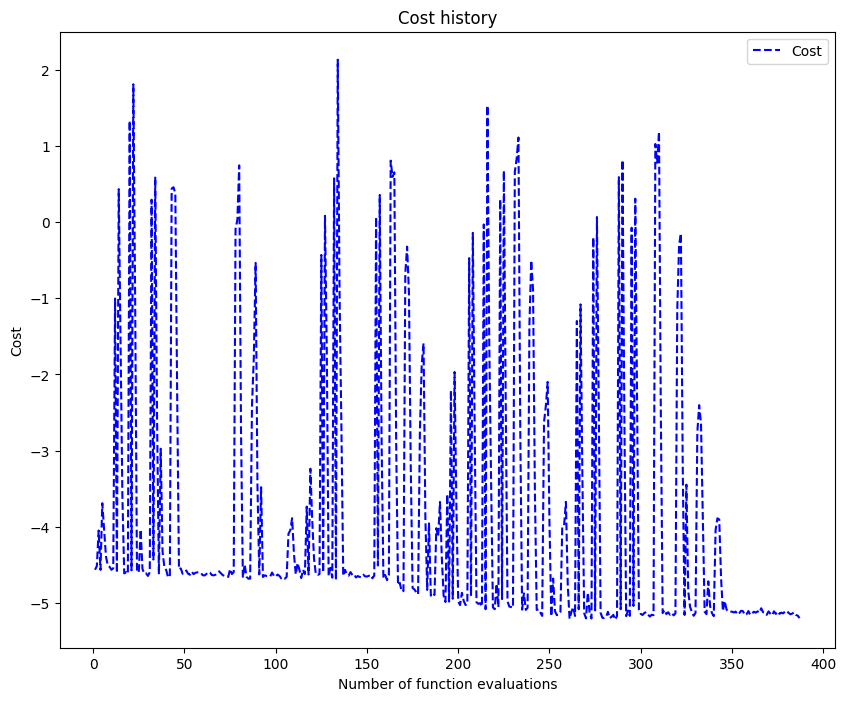

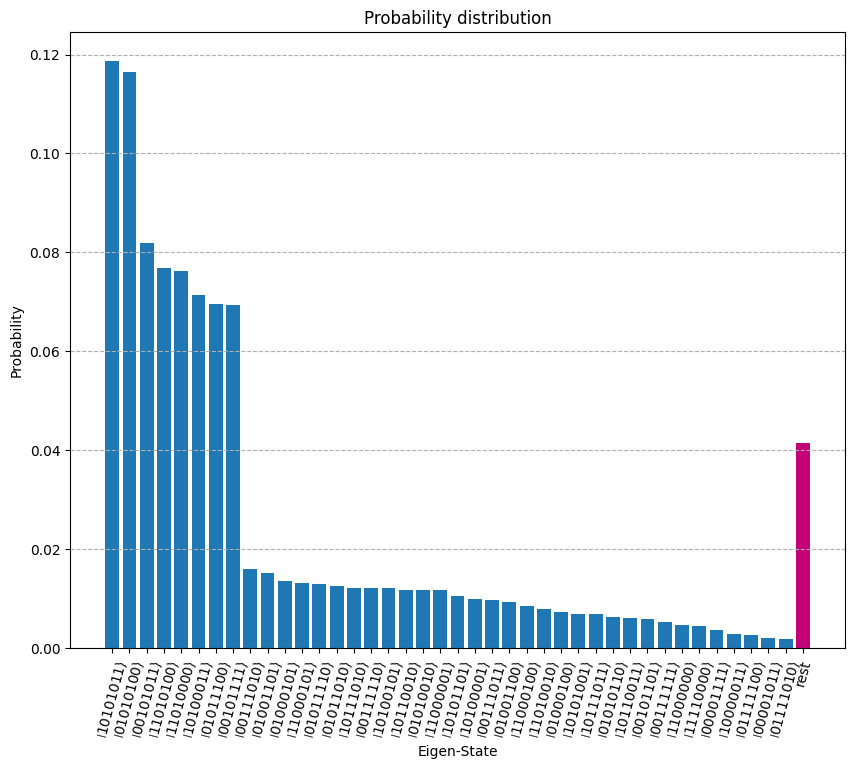

In [16]:
print(opt_results1.lowest_cost_bitstrings(6))
opt_results1.plot_cost()
opt_results1.plot_probabilities()
#q1.solve_brute_force(verbose=True)

# Noisy

In [17]:
q2 = QAOA()
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q2.set_device(qiskit_device)
q2.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
q2.set_backend_properties(n_shots=5000, noise_model=noise_model)
q2.set_classical_optimizer(method='Powell', maxiter=200, tol=0.01,maxfev=1000, optimization_progress=True, cost_progress=True, parameter_log=True)
q2.compile(maxcut_qubo)
q2.backend.parametric_circuit = transpile(q2.backend.parametric_circuit,basis_gates=["h","rx","cx"])
q2.optimize()
opt_results2 = q2.result

In [19]:
q2.backend.parametric_circuit.draw()

┌───┐                                                         »
q2_0: ┤ H ├──■─────────────────────────────────────────■────■───────»
      ├───┤  │                                         │    │       »
q2_1: ┤ H ├──┼─────────────────────────────────────────┼────┼───────»
      ├───┤  │                                         │    │       »
q2_2: ┤ H ├──┼─────────────────────────────────────────┼────┼───────»
      ├───┤  │                                         │    │       »
q2_3: ┤ H ├──┼─────────────────────────────────────────┼────┼───────»
      ├───┤  │                                         │    │       »
q2_4: ┤ H ├──┼─────────────────────────────────────────┼────┼───────»
      ├───┤┌─┴─┐┌───┐┌─────────────────────────┐┌───┐┌─┴─┐  │       »
q2_5: ┤ H ├┤ X ├┤ H ├┤ Rx(2Q_COST_seq0_layer0) ├┤ H ├┤ X ├──┼───────»
      ├───┤└───┘└───┘└─────────────────────────┘└───┘└───┘┌─┴─┐┌───┐»
q2_6: ┤ H ├───────────────────────────────────────────────┤ X ├┤ H ├»
      ├───┤                                               └───┘└───┘»
q2_7: ┤ H ├─────────────────────────────────────────────────────────»
      └───┘                                                         »
«                                                     »
«q2_0: ──────────────────────────────────■────■───────»
«                                        │  ┌─┴─┐┌───┐»
«q2_1: ──────────────────────────────────┼──┤ X ├┤ H ├»
«                                        │  └───┘└───┘»
«q2_2: ──────────────────────────────────┼────────────»
«                                        │            »
«q2_3: ──────────────────────────────────┼────────────»
«                                        │            »
«q2_4: ──────────────────────────────────┼────────────»
«                                        │            »
«q2_5: ──────────────────────────────────┼────────────»
«      ┌─────────────────────────┐┌───┐┌─┴─┐          »
«q2_6: ┤ Rx(2Q_COST_seq1_layer0) ├┤ H ├┤ X ├──────────»
«      └─────────────────────────┘└───┘└───┘          »
«q2_7: ───────────────────────────────────────────────»
«                                                     »
«                                                          »
«q2_0: ──────────────────────────────────■────■────────────»
«      ┌─────────────────────────┐┌───┐┌─┴─┐  │            »
«q2_1: ┤ Rx(2Q_COST_seq2_layer0) ├┤ H ├┤ X ├──┼────■───────»
«      └─────────────────────────┘└───┘└───┘  │    │       »
«q2_2: ───────────────────────────────────────┼────┼───────»
«                                             │    │       »
«q2_3: ───────────────────────────────────────┼────┼───────»
«                                           ┌─┴─┐  │  ┌───┐»
«q2_4: ─────────────────────────────────────┤ X ├──┼──┤ H ├»
«                                           └───┘  │  └───┘»
«q2_5: ────────────────────────────────────────────┼───────»
«                                                ┌─┴─┐┌───┐»
«q2_6: ──────────────────────────────────────────┤ X ├┤ H ├»
«                                                └───┘└───┘»
«q2_7: ────────────────────────────────────────────────────»
«                                                          »
«                                           ┌──────────────────────────┐     »
«q2_0: ──────────────────────────────────■──┤ Rx(1Q_MIXER_seq0_layer0) ├─────»
«                                        │  └──────────────────────────┘     »
«q2_1: ──────────────────────────────────┼───────────────■────────────────■──»
«                                        │               │                │  »
«q2_2: ──────────────────────────────────┼───────────────┼────────────────┼──»
«                                        │               │                │  »
«q2_3: ──────────────────────────────────┼───────────────┼────────────────┼──»
«      ┌─────────────────────────┐┌───┐┌─┴─┐             │              ┌─┴─┐»
«q2_4: ┤ Rx(2Q_COST_seq3_layer0) ├┤ H ├┤ X ├─────────────┼──────────────┤ X ├»
«      └─────────────────────────┘└──

{'solutions_bitstrings': ['11010000', '10100011', '00101011', '01010100', '11010100', '10101011'], 'bitstrings_energies': [-6.0, -6.0, -6.0, -6.0, -6.0, -6.0], 'probabilities': [0.046, 0.0454, 0.0406, 0.0506, 0.0406, 0.0488]}
states kept: 40


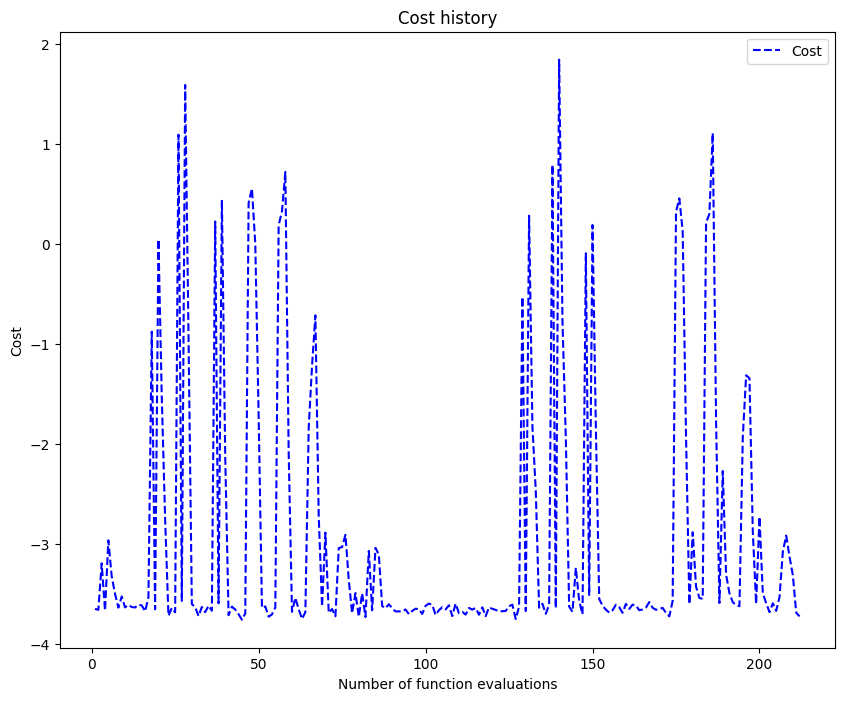

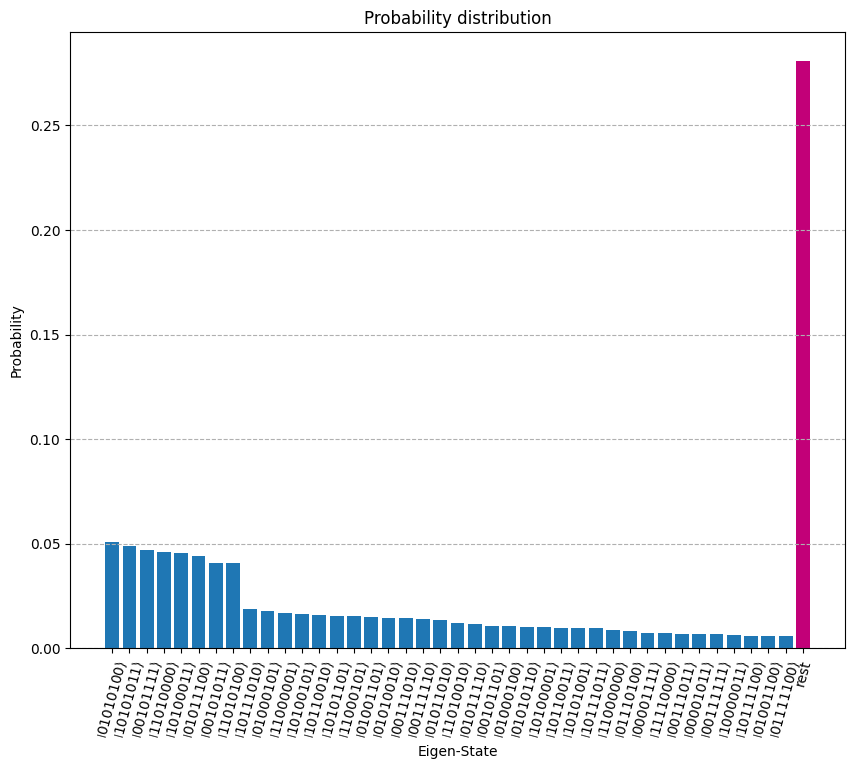

In [20]:
print(opt_results2.lowest_cost_bitstrings(6))
opt_results2.plot_cost()
opt_results2.plot_probabilities()
#q2.solve_brute_force(verbose=True)

# ZNE

In [32]:
q3 = QAOA()
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q3.set_device(qiskit_device)
q3.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
q3.set_backend_properties(n_shots=5000, noise_model=noise_model)
q3.set_classical_optimizer(method='Powell', maxiter=200, tol=0.01,maxfev=1000, optimization_progress=True, cost_progress=True, parameter_log=True)
q3.set_error_mitigation_properties(error_mitigation_technique='mitiq_zne',factory = 'Richardson', scale_factors = [1,2,3])
q3.compile(maxcut_qubo)
#q3.backend.parametric_circuit = transpile(q3.backend.parametric_circuit,basis_gates=["h","rx","cx"])
q3.optimize()
opt_results3 = q3.result

In [33]:
q3.backend.parametric_circuit.draw()

┌───┐                                                         »
q683_0: ┤ H ├──■─────────────────────────────────────────■────■───────»
        ├───┤  │                                         │    │       »
q683_1: ┤ H ├──┼─────────────────────────────────────────┼────┼───────»
        ├───┤  │                                         │    │       »
q683_2: ┤ H ├──┼─────────────────────────────────────────┼────┼───────»
        ├───┤  │                                         │    │       »
q683_3: ┤ H ├──┼─────────────────────────────────────────┼────┼───────»
        ├───┤  │                                         │    │       »
q683_4: ┤ H ├──┼─────────────────────────────────────────┼────┼───────»
        ├───┤┌─┴─┐┌───┐┌─────────────────────────┐┌───┐┌─┴─┐  │       »
q683_5: ┤ H ├┤ X ├┤ H ├┤ Rx(2Q_COST_seq0_layer0) ├┤ H ├┤ X ├──┼───────»
        ├───┤└───┘└───┘└─────────────────────────┘└───┘└───┘┌─┴─┐┌───┐»
q683_6: ┤ H ├───────────────────────────────────────────────┤ X ├┤ H ├»
        ├───┤                                               └───┘└───┘»
q683_7: ┤ H ├─────────────────────────────────────────────────────────»
        └───┘                                                         »
«                                                       »
«q683_0: ──────────────────────────────────■────■───────»
«                                          │  ┌─┴─┐┌───┐»
«q683_1: ──────────────────────────────────┼──┤ X ├┤ H ├»
«                                          │  └───┘└───┘»
«q683_2: ──────────────────────────────────┼────────────»
«                                          │            »
«q683_3: ──────────────────────────────────┼────────────»
«                                          │            »
«q683_4: ──────────────────────────────────┼────────────»
«                                          │            »
«q683_5: ──────────────────────────────────┼────────────»
«        ┌─────────────────────────┐┌───┐┌─┴─┐          »
«q683_6: ┤ Rx(2Q_COST_seq1_layer0) ├┤ H ├┤ X ├──────────»
«        └─────────────────────────┘└───┘└───┘          »
«q683_7: ───────────────────────────────────────────────»
«                                                       »
«                                                            »
«q683_0: ──────────────────────────────────■────■────────────»
«        ┌─────────────────────────┐┌───┐┌─┴─┐  │            »
«q683_1: ┤ Rx(2Q_COST_seq2_layer0) ├┤ H ├┤ X ├──┼────■───────»
«        └─────────────────────────┘└───┘└───┘  │    │       »
«q683_2: ───────────────────────────────────────┼────┼───────»
«                                               │    │       »
«q683_3: ───────────────────────────────────────┼────┼───────»
«                                             ┌─┴─┐  │  ┌───┐»
«q683_4: ─────────────────────────────────────┤ X ├──┼──┤ H ├»
«                                             └───┘  │  └───┘»
«q683_5: ────────────────────────────────────────────┼───────»
«                                                  ┌─┴─┐┌───┐»
«q683_6: ──────────────────────────────────────────┤ X ├┤ H ├»
«                                                  └───┘└───┘»
«q683_7: ────────────────────────────────────────────────────»
«                                                            »
«                                             ┌──────────────────────────┐     »
«q683_0: ──────────────────────────────────■──┤ Rx(1Q_MIXER_seq0_layer0) ├─────»
«                                          │  └──────────────────────────┘     »
«q683_1: ──────────────────────────────────┼───────────────■────────────────■──»
«                                          │               │                │  »
«q683_2: ──────────────────────────────────┼───────────────┼────────────────┼──»
«                                          │               │                │  »
«q683_3: ──────────────────────────────────┼───────────────┼────────────────┼──»
«        ┌─────────────────────────┐┌───┐┌─┴─┐             │              ┌─┴─┐

{'solutions_bitstrings': ['01010100', '00101111', '00101011', '10100011', '10101011', '11010000'], 'bitstrings_energies': [-6.0, -6.0, -6.0, -6.0, -6.0, -6.0], 'probabilities': [0.0029296875, 0.005859375, 0.021484375, 0.0146484375, 0.00390625, 0.0068359375]}
states kept: 40


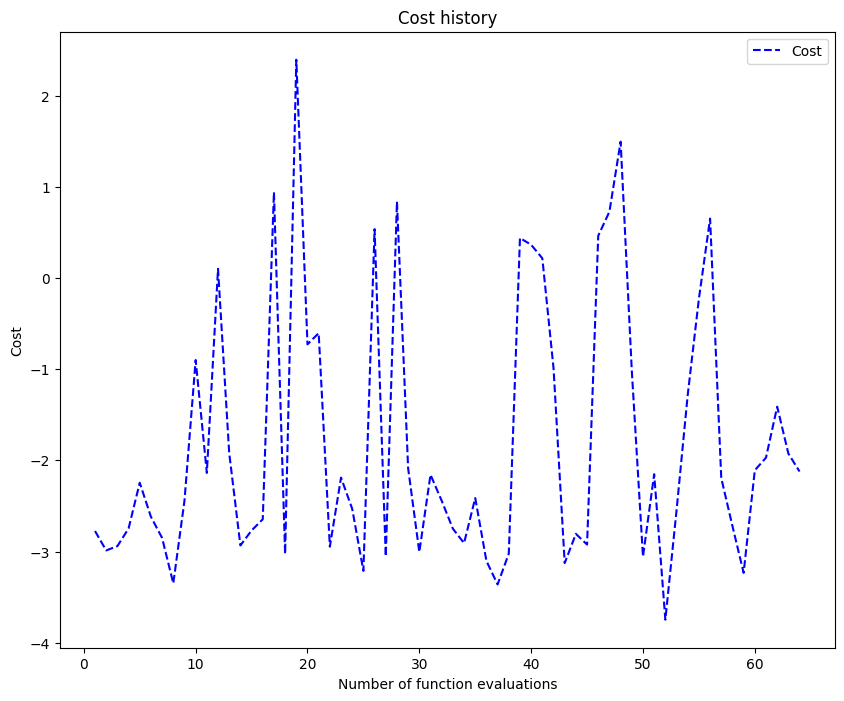

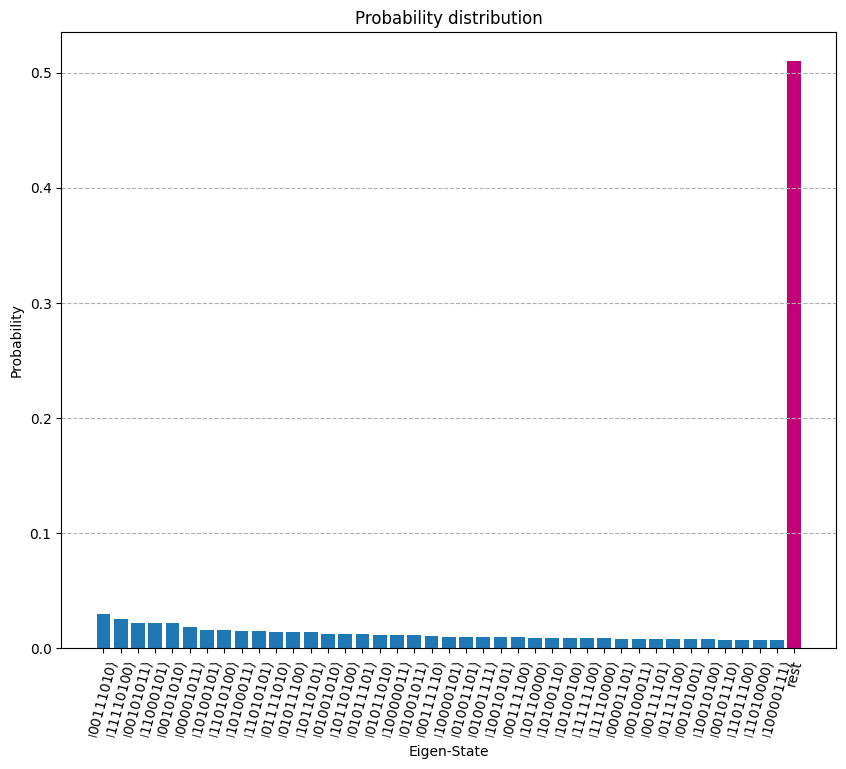

In [34]:
print(opt_results3.lowest_cost_bitstrings(6))
opt_results3.plot_cost()
opt_results3.plot_probabilities()
#q3.solve_brute_force(verbose=True)

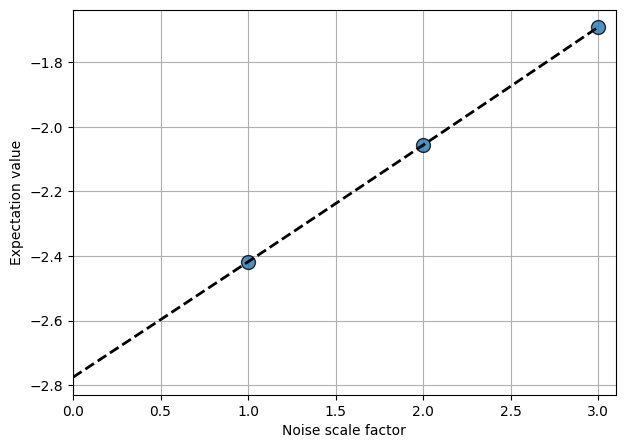

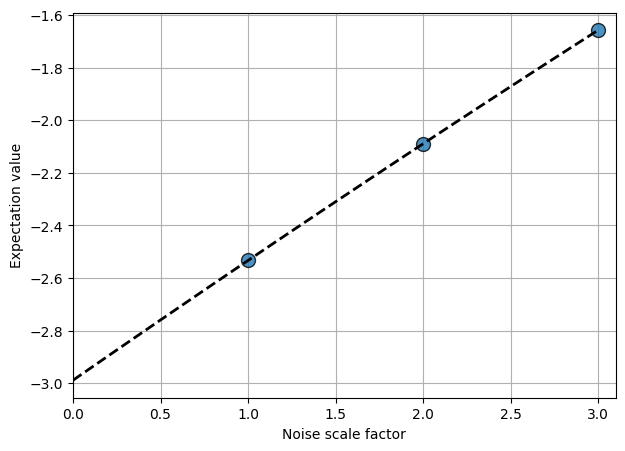

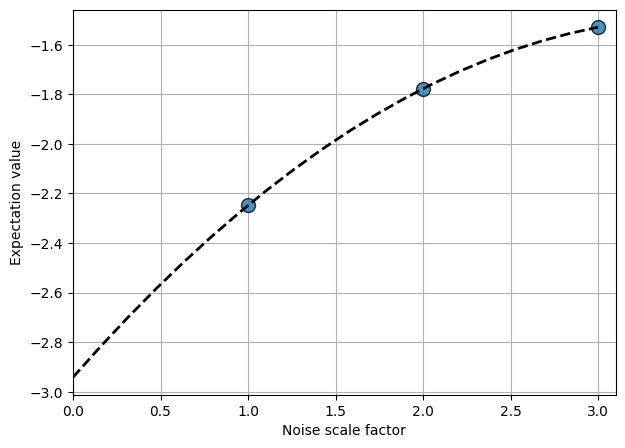

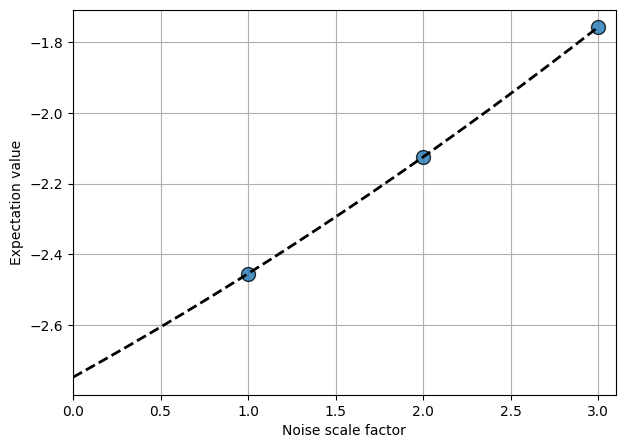

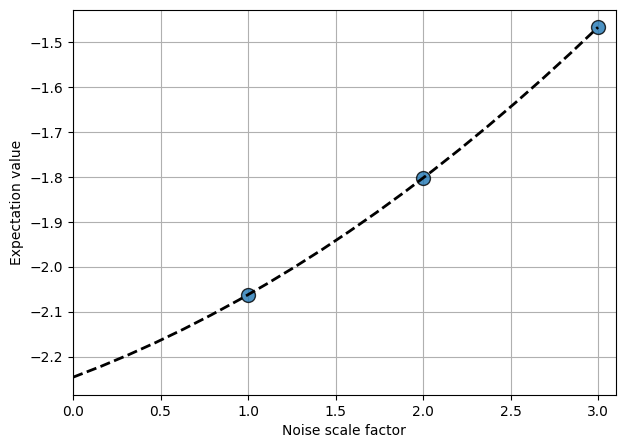

In [35]:
for i in q3.backend.result_factory_objs[0:5]:
    i.plot_fit()

# All cost plots

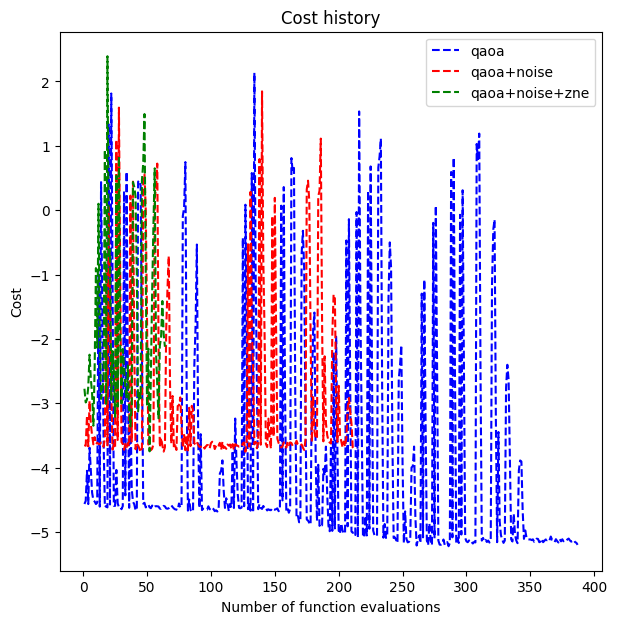

In [36]:
fig, ax = plt.subplots(figsize=(7,7))
opt_results1.plot_cost(figsize=(7,7),color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(figsize=(7,7),color='red',label='qaoa+noise',ax=ax)
opt_results3.plot_cost(figsize=(7,7),color='green',label='qaoa+noise+zne',ax=ax) 